In [10]:
from pyproj import datadir
datadir.set_data_dir("/home/jupyter-daniela/.conda/envs/peru_environment/share/proj")

In [11]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import cmocean
import re

path_features = Path("/home/jupyter-daniela/suyana/peru_production/features/")

archivos = [
    f for f in path_features.glob("hycom_*.nc")
    if re.match(r"hycom_(1ra|2da)-\d{4}\.nc$", f.name)
]

def orden_temporada(f):
    m = re.match(r"hycom_(1ra|2da)-(\d{4})\.nc$", f.name)
    if m:
        temporada, anio = m.groups()
        orden_t = 0 if temporada == "1ra" else 1
        return int(anio), orden_t
    return (9999, 9)

archivos_ordenados = sorted(archivos, key=orden_temporada)


In [12]:
df_calas = pd.read_csv("/home/jupyter-daniela/suyana/peru_production/outputs/calas_all_data.csv", low_memory=False)


empresas_equivalentes = {
    "AUSTRAL GROUP SAA": "AUSTRAL GROUP SAA",
    "CFG-COPEINCA": "COPEINCA",
    "HAYDUK": "HAYDUK",
    "TASA": "TASA",
    "TASA ": "TASA",
    "PESQUERA CENTINELA S.A.C": "CENTINELA S.A.C",
    "CENTINELA": "CENTINELA S.A.C",
    "PESQUERA DIAMANTE S.A.": "DIAMANTE S.A.",
    "DIAMANTE": "DIAMANTE S.A.",
    "Pesquera Diamante S.A.": "DIAMANTE S.A.",
    "PESQUERA EXALMAR S.A.A.": "EXALMAR S.A.A.",
    "CAPRICORNIO": "CAPRICORNIO",
    "INVERSIONES QUIAZA SAC": "INVERSIONES QUIAZA SAC",
    "QUIAZA": "INVERSIONES QUIAZA SAC",
    "PESQ. ISA": "ISA",
    "LOS HALCONES SA": "LOS HALCONES SA",
    "LOS HALCONES": "LOS HALCONES SA",
    "Inversiones Eccola": "INVERSIONES ECCOLA",
    "INVERSIONES ECCOLA": "INVERSIONES ECCOLA",
    "PESQ. NINFAS DEL MAR": " NINFAS DEL MAR",
    "PESQ. MAJAT": "MAJAT",
    "PESQUERA LUCIANA SAC": "LUCIANA SAC",
    "PESQUERA SKAVOS S.A.C.": "SKAVOS S.A.C."
}

df_calas["empresa_normalizada"] = df_calas["empresa"].replace(empresas_equivalentes)


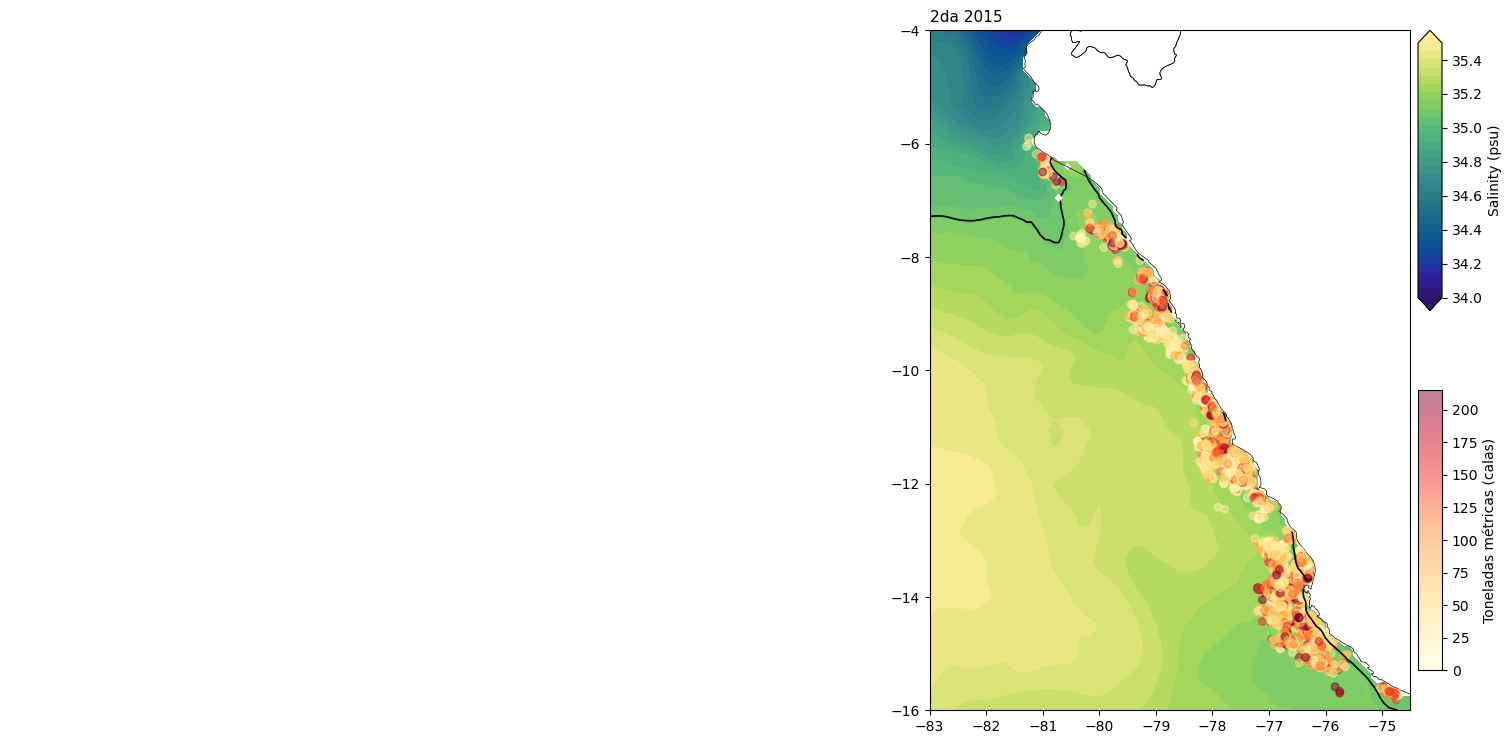

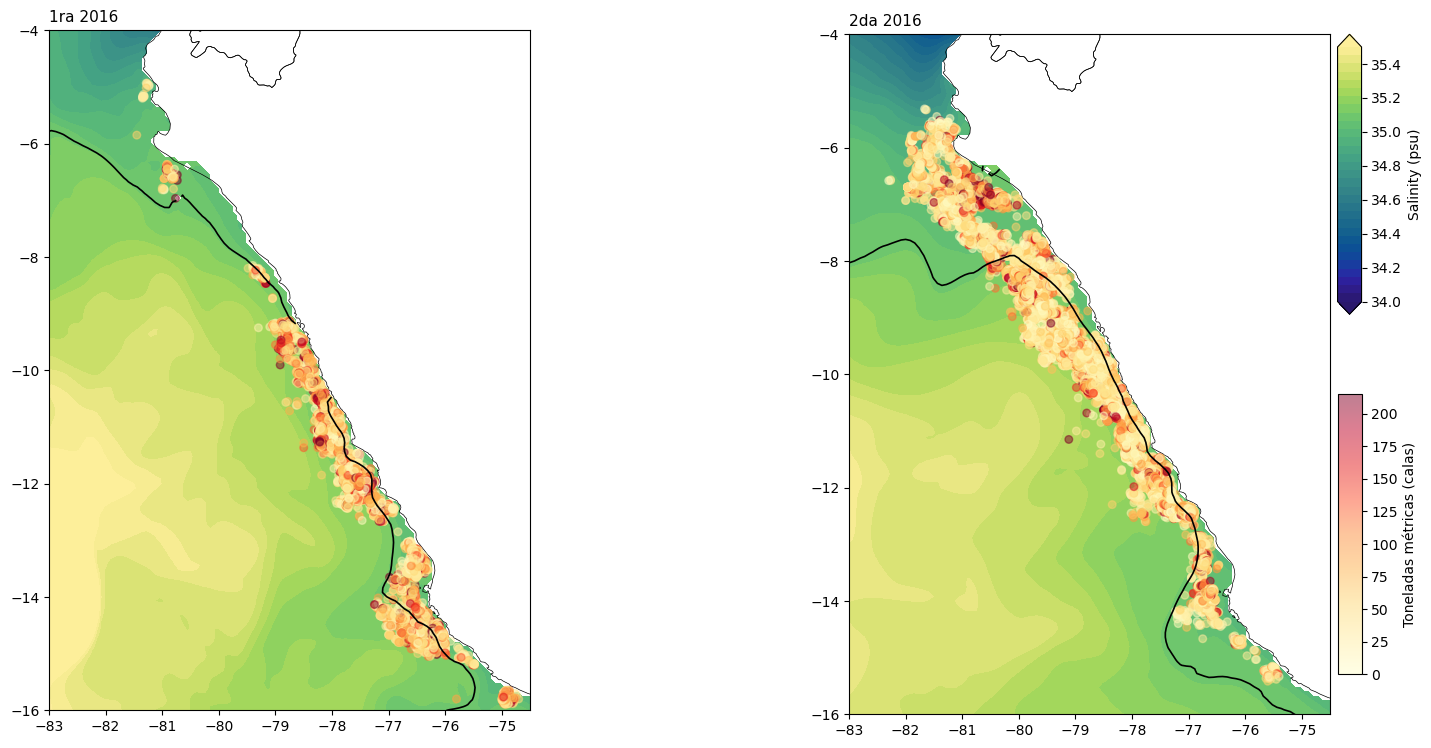

In [ ]:

path_features = Path("/home/jupyter-daniela/suyana/peru_production/features/")
path_output = Path("/home/jupyter-daniela/suyana/peru_production/displays/")
boundary = gpd.read_file("/home/jupyter-daniela/suyana/geometries/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")

archivos = [
    f for f in path_features.glob("hycom_*.nc")
    if re.match(r"hycom_(1ra|2da)-\d{4}\.nc$", f.name)
]

def orden_temporada(f):
    m = re.match(r"hycom_(1ra|2da)-(\d{4})\.nc$", f.name)
    if m:
        temporada, anio = m.groups()
        return int(anio), 0 if temporada == "1ra" else 1
    return (9999, 9)

archivos_ordenados = sorted(archivos, key=orden_temporada)
anios = sorted(set(int(re.search(r"(\d{4})", f.name).group(1)) for f in archivos_ordenados))

levels = np.linspace(34, 35.5, 32)
ticks = np.arange(34, 35.5, 0.2)


for anio in anios:
    fig = plt.figure(figsize=(16, 8))
    axes = [plt.axes([0.05, 0.055, 0.45, 0.85]), plt.axes([0.55, 0.05, 0.45, 0.85])]

    for j, temporada in enumerate(["1ra", "2da"]):
        fname = next((f for f in archivos_ordenados if f"_{temporada}-{anio}" in f.name), None)
        ax = axes[j]

        if fname is None:
            ax.axis("off")
            continue

        ds = xr.open_dataset(fname)
        if (ds.lon > 180).any():
            ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
            ds = ds.sortby(ds.lon)

        sal_mean = ds["salinity"].mean("time")

        cf = ax.contourf(
            ds["lon"], ds["lat"], sal_mean,
            levels=levels, cmap=cmocean.cm.haline, extend="both"
        )
        ax.contour(ds["lon"], ds["lat"], sal_mean, levels=[35.1], colors="black", linewidths=1.2)

        boundary.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5)

        df_calas["anio"] = df_calas["temporada"].str.extract(r"(\d{4})").astype(int)
        df_calas = df_calas.rename(columns={"latitud ": "latitud"})

        df_temp = df_calas[(df_calas["anio"] == anio) & (df_calas["temporada"].str.contains(temporada, case=False))]

        if not df_temp.empty:
            sc = ax.scatter(
                df_temp["longitud"], df_temp["latitud"],
                c=df_temp["declarado_tm"],
                cmap="YlOrRd", alpha=0.5, s=30,
                vmin=0, vmax=df_calas["declarado_tm"].quantile(0.95)
            )

        ax.set_xlim([-83, -74.5])
        ax.set_ylim([-16, -4])
        ax.set_title(f"{temporada} {anio}", fontsize=11, loc="left")

    cax1 = fig.add_axes([0.93, 0.55, 0.015, 0.35])
    fig.colorbar(cf, cax=cax1, ticks=ticks, label="Salinity (psu)")

    cax2 = fig.add_axes([0.93, 0.1, 0.015, 0.35])
    fig.colorbar(sc, cax=cax2, label="Toneladas métricas (calas)")

    fig.savefig(path_output / f"hycom_calas_{anio}.png", bbox_inches="tight")


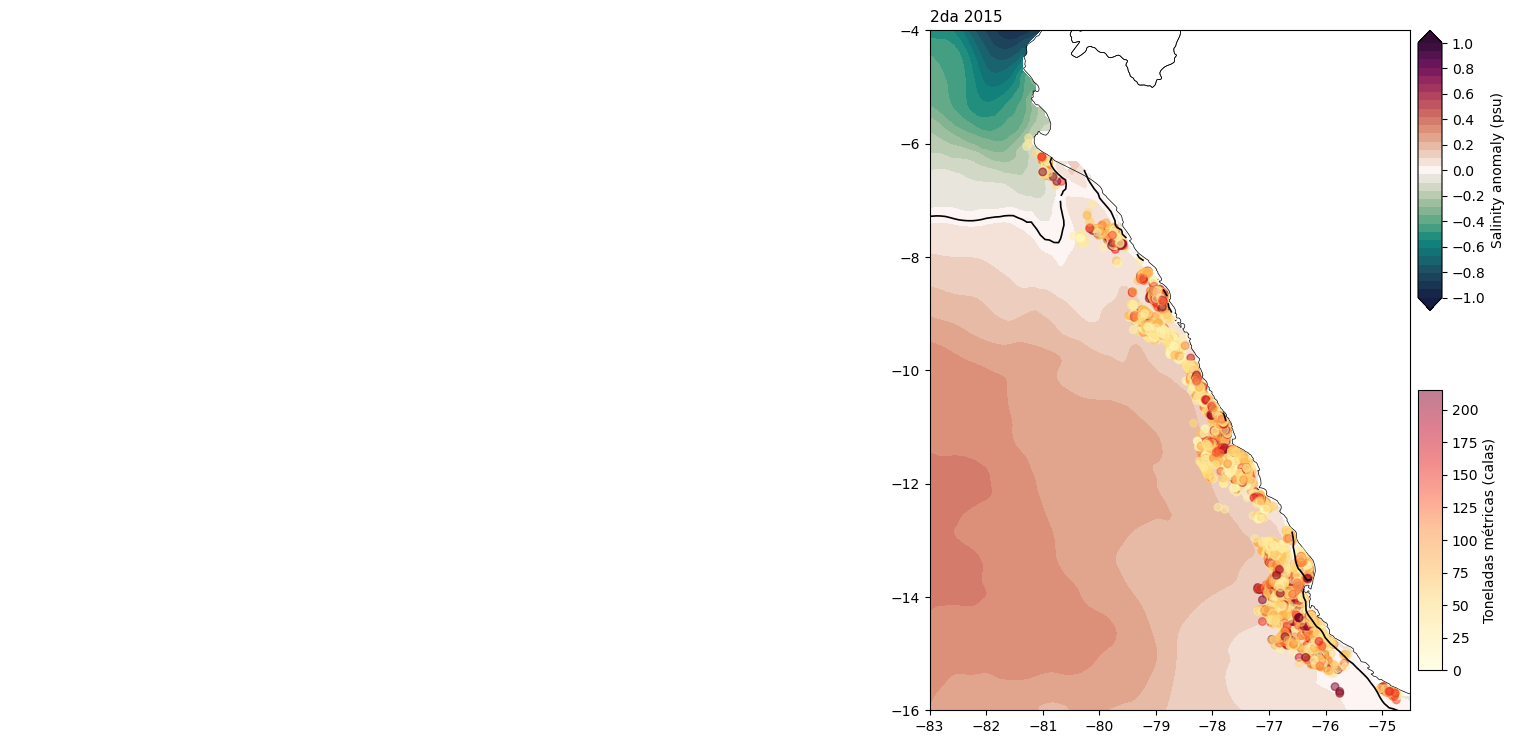

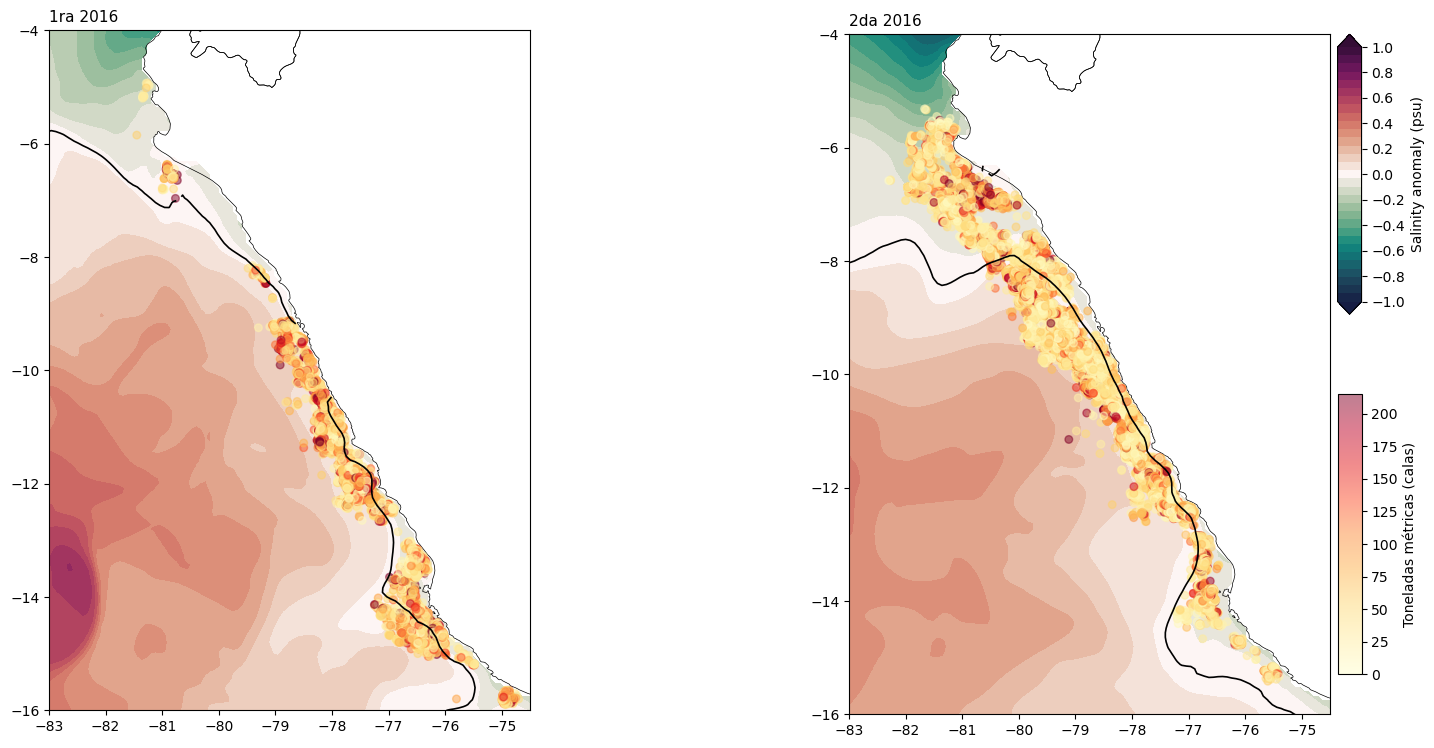

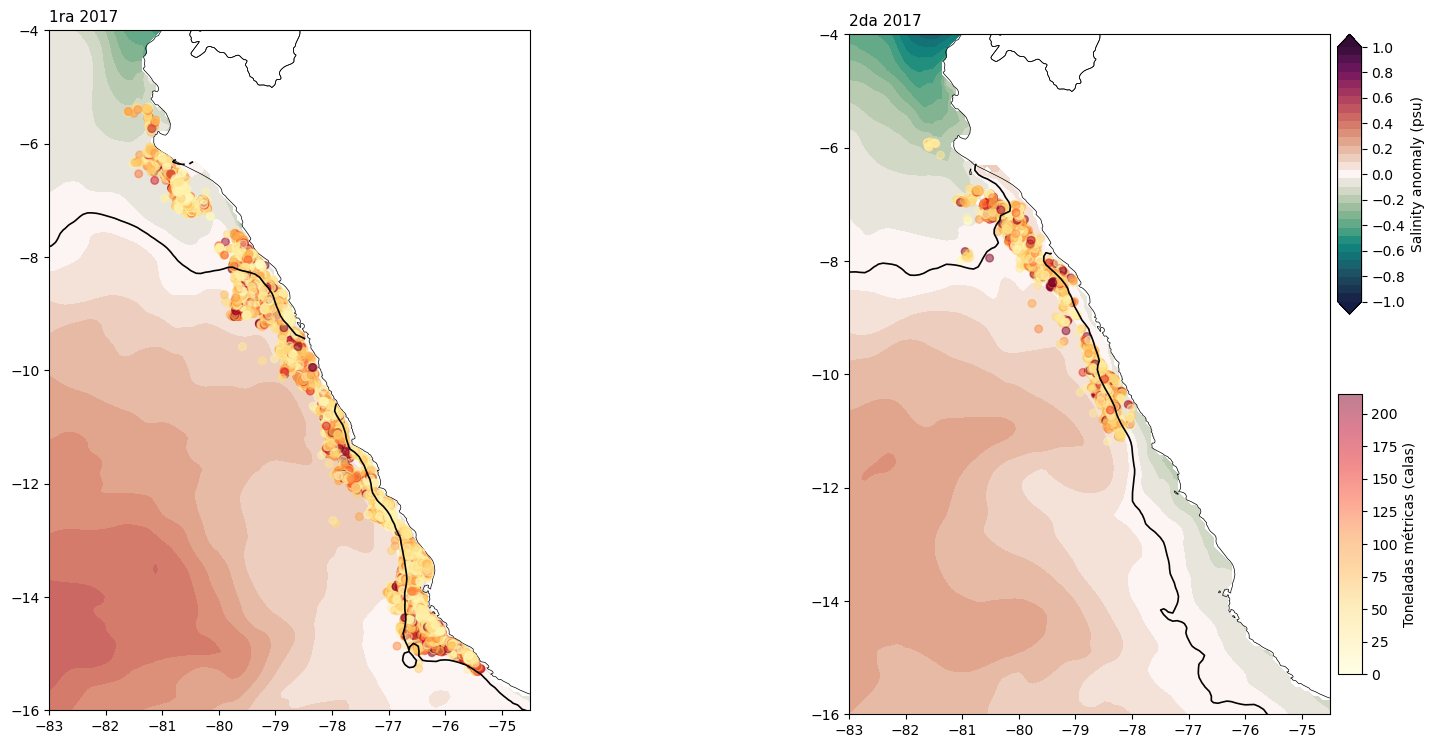

In [15]:
levels = np.linspace(-1.0, 1.0, 32)
ticks = np.arange(-1.0, 1.1, 0.2)

for anio in anios:
    fig = plt.figure(figsize=(16, 8))
    axes = [plt.axes([0.05, 0.055, 0.45, 0.85]), plt.axes([0.55, 0.05, 0.45, 0.85])]

    for j, temporada in enumerate(["1ra", "2da"]):
        fname = next((f for f in archivos_ordenados if f"_{temporada}-{anio}" in f.name), None)
        ax = axes[j]

        if fname is None:
            ax.axis("off")
            continue

        ds = xr.open_dataset(fname)
        if (ds.lon > 180).any():
            ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
            ds = ds.sortby(ds.lon)

        sal_mean = ds["salinity"].mean("time")
        sal_anom = sal_mean - 35.1  # ← anomalías respecto a 35.1 psu

        cf = ax.contourf(
            ds["lon"], ds["lat"], sal_anom,
            levels=levels, cmap=cmocean.cm.curl, extend="both"
        )
        ax.contour(ds["lon"], ds["lat"], sal_anom, levels=[0], colors="black", linewidths=1.2)

        boundary.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5)

        df_calas["anio"] = df_calas["temporada"].str.extract(r"(\d{4})").astype(int)
        df_calas = df_calas.rename(columns={"latitud ": "latitud"})

        df_temp = df_calas[(df_calas["anio"] == anio) &
                           (df_calas["temporada"].str.contains(temporada, case=False))]

        if not df_temp.empty:
            sc = ax.scatter(
                df_temp["longitud"], df_temp["latitud"],
                c=df_temp["declarado_tm"],
                cmap="YlOrRd", alpha=0.5, s=30,
                vmin=0, vmax=df_calas["declarado_tm"].quantile(0.95)
            )

        ax.set_xlim([-83, -74.5])
        ax.set_ylim([-16, -4])
        ax.set_title(f"{temporada} {anio}", fontsize=11, loc="left")

    cax1 = fig.add_axes([0.93, 0.55, 0.015, 0.35])
    fig.colorbar(cf, cax=cax1, ticks=ticks, label="Salinity anomaly (psu)")

    cax2 = fig.add_axes([0.93, 0.1, 0.015, 0.35])
    fig.colorbar(sc, cax=cax2, label="Toneladas métricas (calas)")

    fig.savefig(path_output / f"hycom_anomalias_calas_{anio}.png", bbox_inches="tight")